# Text Module Tutorial 1: Preprocessing

This tutorial demonstrates how the text module can be used to perform various preprocessing steps on text data. Plots and other functions are used to compare the processed dataset compared to the raw dataset.

In [3]:
# basic manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.cluster import KMeans
from gensim.models.doc2vec import Doc2Vec

# pvops functionality
from pvops.text import utils as text_utils
from pvops.text import nlp_utils as text_nlp_utils
from pvops.text import visualize as text_visualize
from pvops.text import preprocess as text_preprocess

### Initial data cleaning and exploration

Here, we read in our example dataset.

In [4]:
df = pd.read_csv('example_data/example_ML_ticket_data.csv')
df.head(5)

Date_EventStart    Date_EventEnd     Asset  \
0   8/16/2018 9:00  8/22/2018 17:00  Combiner   
1  9/17/2018 18:25   9/18/2018 9:50       Pad   
2   8/26/2019 9:00  11/5/2019 17:00  Facility   
3  11/14/2017 7:46  11/14/2017 8:35  Inverter   
4   4/27/2019 9:00   5/2/2019 17:00  Facility   

                                      CompletionDesc  \
0  cb 1.18 was found to have contactor issue woul...   
1                  self resolved. techdispatched: no   
2  all module rows washed, waiting for final repo...   
3  14 nov: we were alerted that e-c3-1 had faulte...   
4  assessed condition filters all inverters. litt...   

                             Cause       ImpactLevel  randid  
0                 0000 - Unknown.   Underperformance      38  
1            004 - Under voltage.   Underperformance      46  
2                   0000 - Unknown  Underperformance      62  
3  019 - Unplanned outage/derate.   Underperformance      54  
4                               .                NaN      45

Before performing text analysis, it may be necessary to clean up categorical labels to make the data easier to work with.

`example_data/remappings_asset.csv` has a helpful mapping for us. It consists of two columns: `in`, which is the input of our mapping, and `out_`, which is the corresponding output. `pvops.text.utils` offers a function `remap_attributes` to help us perform this remapping.

In [5]:
remapping_df = pd.read_csv('example_data/remappings_asset.csv')

remapping_col_dict = {
    'attribute_col': 'Asset',
    'remapping_col_from': 'in',
    'remapping_col_to': 'out_'
}

df = text_utils.remap_attributes(df, remapping_df, remapping_col_dict, allow_missing_mappings=True)
df['Asset'].value_counts()

Asset
facility          37
inverter          34
tracker            8
combiner           7
met station        3
substation         3
transformer        2
module             2
other              2
energy storage     1
energy meter       1
Name: count, dtype: int64

Let's obtain a basic summary of the asset labels using `pvops.nlp_utils.summarize_text_data`. We can also plot the distibution of asset labels over time.

DETAILS
  100 samples
  0 invalid documents
  1.05 words per sample on average
  Number of unique words 13
  105.00 total words


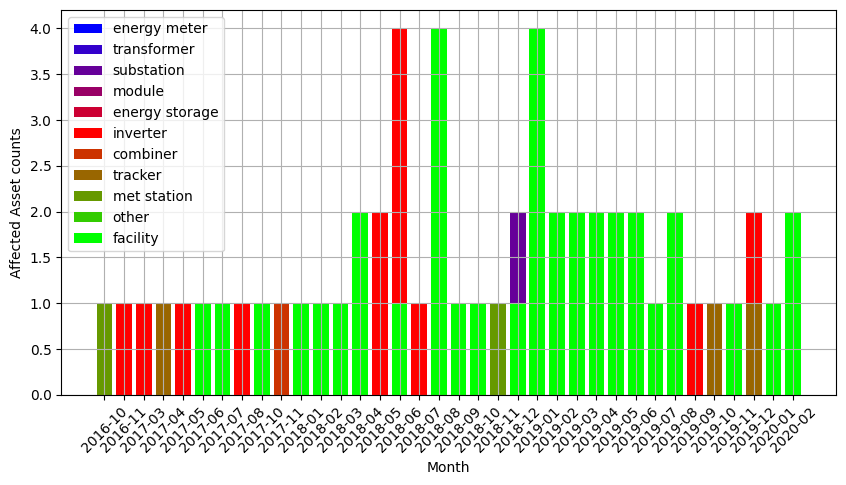

In [6]:
text_nlp_utils.summarize_text_data(df, 'Asset')

df_to_plot = df.copy()
df_to_plot['Date_EventStart'] = pd.to_datetime(df['Date_EventStart'])
df_to_plot = df_to_plot.loc[df_to_plot['Date_EventStart'].notnull()]

_, ax = plt.subplots(figsize=(10,5))
text_visualize.visualize_attribute_timeseries(df_to_plot, dict(date='Date_EventStart', label='Asset'), ax=ax);

### text.preprocess submodule

The `pvops.text.preprocess` submodule performs some initial preprocessing steps to prepare textual data for machine learning. It offers its primary functionality through the `preprocessor()` function, which takes a `DataFrame` as input. This dataframe must have, at a minimum, a column that stores text logs and a column that stores the associated datetimes. The function then performs three primary steps:

1. Removes from the text column any numbers which might be confused for dates using `pvops.text.preprocess.text_remove_nondate_nums()`.

2. Extracts dates using `pvops.text.preprocess.get_dates()`, considering both the text column and the datetime column, and only extracting dates after performing some basic quality control checks.

3. Cleans the text data, removing numbers as well as any stopwords passed into the function's `lst_stopwords` argument using `pvops.text.preprocess.text_remove_numbers_stopwords()`.

In the example below, we leverage the `preprocessor` function to clean up our text data:

In [7]:
# drop null rows
preprocessed_df = df.copy().dropna(subset=['Asset', 'CompletionDesc'])

# let's only keep asset labels which have more than one instance in the dataset
label_counts = preprocessed_df.value_counts('Asset')
labels_with_multiple_occurrences = label_counts.loc[label_counts > 1].index
preprocessed_df = preprocessed_df.loc[preprocessed_df['Asset'].isin(labels_with_multiple_occurrences)]

# bulid a custom set of stopwords
stopwords = text_nlp_utils.create_stopwords(lst_add_words=['dtype', 'say', 'length', 'object', 'u', 'ha', 'wa'])

# run our preprocessing function to clean up the text data and prepare it for ML
col_dict = dict(data='CompletionDesc',
                eventstart='Date_EventStart',
                save_data_column='CleanDesc',
                save_date_column='ExtractedDates')

preprocessed_df = text_preprocess.preprocessor(preprocessed_df, stopwords, col_dict)
preprocessed_df.head()[['CompletionDesc', 'CleanDesc']]

CompletionDesc  \
0  cb 1.18 was found to have contactor issue woul...   
1                  self resolved. techdispatched: no   
2  all module rows washed, waiting for final repo...   
3  14 nov: we were alerted that e-c3-1 had faulte...   
4  assessed condition filters all inverters. litt...   

                                           CleanDesc  
0  cb found contactor issue would close contactor...  
1                       self resolved techdispatched  
2  module rows washed waiting final report sun power  
3  nov alerted e c faulted upon investigation not...  
4  assessed condition filters inverters little cl...

Sometimes, a row may be missing the date in the appropriate timestamp column, but dates may still be provided in textual columns. In a case like this, we can also use the `preprocessor` function. Note this function isn't 100% perfect, but should provide a good first pass attempt. Using the optional argument `extract_dates_only=True`, we can tell the function to only perform the date extraction (and not waste time removing stopwords).

In [8]:
dates_df = text_preprocess.preprocessor(df, None, col_dict, extract_dates_only=True)
dates_df.head()[['CompletionDesc', 'ExtractedDates']]

CompletionDesc  \
0  cb 1.18 was found to have contactor issue woul...   
1                  self resolved. techdispatched: no   
2  all module rows washed, waiting for final repo...   
3  14 nov: we were alerted that e-c3-1 had faulte...   
4  assessed condition filters all inverters. litt...   

                               ExtractedDates  
0                                          []  
1                                          []  
2                       [2019-09-01 09:00:00]  
3  [2017-11-14 07:46:00, 2017-03-01 07:46:00]  
4                                          []

Let's go back to our ML-prepped text, which we stored in the `'CleanDesc'` column of `preprocessed_df`. pvOps provides a few different ways of exploring how these preprocessing steps have modified the dataset. To start, we can see a set of simple statistics pre- and post-preprocessing:

In [9]:
print('Pre-text processing:')
text_nlp_utils.summarize_text_data(df, 'CompletionDesc')

print('\nPost-text processing')
text_nlp_utils.summarize_text_data(preprocessed_df, 'CleanDesc');

Pre-text processing:
DETAILS
  100 samples
  0 invalid documents
  33.52 words per sample on average
  Number of unique words 1213
  3352.00 total words

Post-text processing
DETAILS
  98 samples
  0 invalid documents
  20.72 words per sample on average
  Number of unique words 726
  2031.00 total words


We can also consider the embeddings of our documents and quantify how distinct those embeddings are from each other. The function `pvops.text.visualize.visualize_cluster_entropy` will compute the Doc2Vec embedding of each row, cluster the embeddings using KMeans, and plot the sum-of-square distance from the embeddings to their respective cluster centroids (known as "inertia" in the context of KMeans).

The resulting plot below demonstrates that the embeddings of the cleaned descriptions are much more "distinct", in the sense that they are further apart in embedding space and hence easier to differentiate.

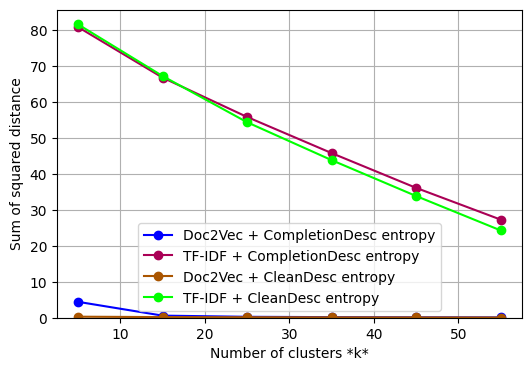

In [10]:
doc2vec_model = Doc2Vec(vector_size=40, min_count=2)
k_vals = np.arange(5, 56, 10)
eval_kmeans = lambda X, k: KMeans(n_clusters=k, n_init=5).fit(X)

_, ax = plt.subplots(figsize=(6,4))
text_visualize.visualize_cluster_entropy(doc2vec_model, eval_kmeans, preprocessed_df, ['CompletionDesc', 'CleanDesc'], k_vals, cmap_name='brg', ax=ax);

We can also, for instance, extract the documents labeled with an "inverter" asset and plot the frequency of the most commonly occuring words in the raw description, and then the cleaned one. We see that the "clean" version has a much more intuitive selection of words:

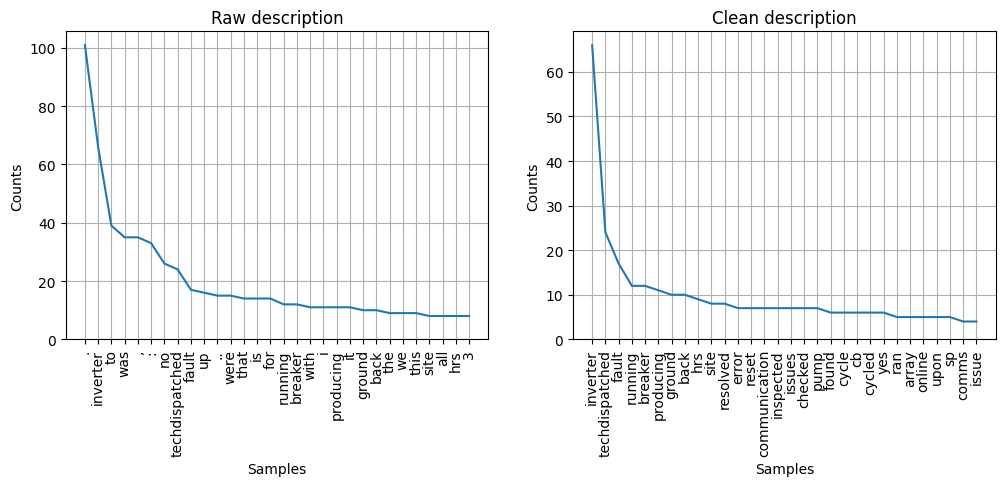

In [11]:
inverter_documents_raw = preprocessed_df.loc[preprocessed_df['Asset'] == 'inverter', 'CompletionDesc']
tokenized_raw = text_preprocess.regex_tokenize(' '.join(inverter_documents_raw))

inverter_documents_clean = preprocessed_df.loc[preprocessed_df['Asset'] == 'inverter', 'CleanDesc']
tokenized_clean = text_preprocess.regex_tokenize(' '.join(inverter_documents_clean))

_, axes = plt.subplots(ncols=2, figsize=(12,4))
text_visualize.visualize_word_frequency_plot(tokenized_raw, 'Raw description', ax=axes[0]);
text_visualize.visualize_word_frequency_plot(tokenized_clean, 'Clean description', ax=axes[1]);

Finally, using the `pvops.text.visualize.visualize_attribute_connectivity` function, we can plot the correspondence between two columns in our dataset. Below, we can qualitatively see how often each asset type (the top row) is associated with each impact level (the bottom row).

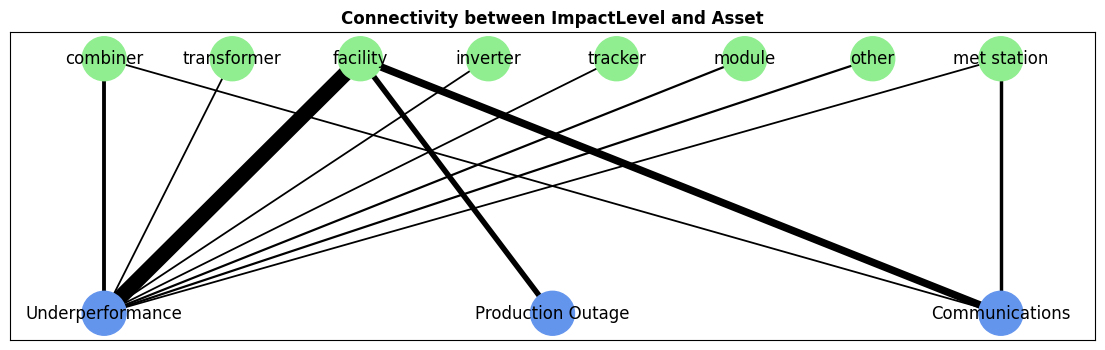

In [12]:
attributes_dict = dict(attribute1_col='Asset', attribute2_col='ImpactLevel')
filtered_df = preprocessed_df.dropna(subset=attributes_dict.values())

_, ax = plt.subplots(figsize=(14,4))
text_visualize.visualize_attribute_connectivity(filtered_df, attributes_dict, ax=ax, graph_aargs=dict(node_size=1000));